# ERO2 : Un petit TP

Ce document est à compléter, il sert d'évaluation sommative pour la première itération du cours d'ERO2. Merci de formuler vos questions sur le forum moodle prévu à cet effet.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

## *Given Files*

Cette section regroupe les éléments déjà préalablement à votre disposition, vous êtes libres de vous en servir pour répondre aux différentes questions du TP.

In [3]:
class Wline():

    def __init__(self, size=None, policy=(lambda x: 0)): #here this is fifo, lambda x:-1 would be lifo
        self.size = size
        self.next = policy
        self.queue = []
        
    def populate(self, queue):
        if self.size is not None and len(queue) > self.size:
            print(f"Error: The size of the input queue is larger than the maximum size {self.size}.")
            return
        self.queue = queue
        
    def add(self, item):
        if self.size is None or len(self.queue) < self.size:
            self.queue.append(item)
            return True
        else:
            print("Error: The queue is full. Cannot add more items.")
            return False
    
    def pop(self):
        pop_ix = self.next(self.queue)
        pop_val = None

        if -len(self.queue) <= pop_ix < len(self.queue) : # Here there was a mistake, it's "<=" not "<"
            pop_val = self.queue[pop_ix]
            self.queue.pop(pop_ix)
            
        return pop_val
    def is_empty(self):
        return len(self.queue) == 0

In [4]:
#Since apparently there are issues in the code I will need to thoroughly test everything


def test_Wline():

    # Test FIFO behavior
    queue = Wline(size=3, policy=(lambda x: 0))
    queue.populate([1, 2, 3])
    assert queue.pop() == 1, "Error in test_Wline: FIFO behavior not working correctly."
    assert queue.pop() == 2, "Error in test_Wline: FIFO behavior not working correctly."
    assert queue.pop() == 3, "Error in test_Wline: FIFO behavior not working correctly."
    
    # Test LIFO behavior
    queue = Wline(size=3, policy=(lambda x: -1))
    queue.populate([1, 2, 3])
    assert queue.pop() == 3, "Error in test_Wline: LIFO behavior not working correctly."
    assert queue.pop() == 2, "Error in test_Wline: LIFO behavior not working correctly."
    assert queue.pop() == 1, "Error in test_Wline: LIFO behavior not working correctly."
    assert queue.pop() == None

    # Test size limit
    queue = Wline(size=3)
    queue.populate([1, 2, 3, 4])  # This should print an error message
    queue.populate([1, 2, 3])
    queue.add(4)  # This should also print an error message
    assert len(queue.queue) == 3, "Error in test_Wline: Size limit not working correctly."
    
    print("All tests passed successfully.")
    
# Run the tests
test_Wline()


Error: The size of the input queue is larger than the maximum size 3.
Error: The queue is full. Cannot add more items.
All tests passed successfully.


In [5]:
class InService():
    
    def __init__(self, nb=1, dist=None):
        self.nb = nb
        self.server = [None]*nb
        self.dist = dist
        
    def full(self):
        return not (None in self.server)
        
    def leaving(self, tops):
        
        agent_id = None
        
        if not self.full():
            #Extract index of an available server
            srv_ix = self.server.index(None) 
        
        else:
            #Find agent of smallest departure time, needs to be float to use idxmin
            agent_id = tops.loc[self.server, 't_depart_sys'].astype(float).idxmin()
            #Extract server number of departing agent
            srv_ix = self.server.index(agent_id) 
        
        return srv_ix, agent_id

In [6]:
class QS():
    
    def __init__(self, arval_dist, srv_dist, servers_nb, 
                 queue_size=None, policy=lambda x:0, test_size=100) :
         
        #Initializing metadata
        self.arval_dist = arval_dist
        self.srv_dist = srv_dist
        self.srv_z = servers_nb
        self.queue_z = queue_size if queue_size else test_size
        self.test_z = test_size

        #Initializing Waiting Line
        self.wline = Wline(size=queue_size, policy=policy)
        
        #Initializing In Service List
        self.inservice = InService(nb=servers_nb, dist=srv_dist)
        
        #Initializin tops dataframe
        column_names = ['t_arval_queue', 't_arval_srv', 't_depart_sys']
        self.tops = pd.DataFrame(np.empty((test_size, 3),dtype=object), columns=column_names)
        
    def pretreat(self):
        
        #Easing naming
        tops = self.tops

        t_interarvals = self.arval_dist(size=(self.test_z))
        tops.loc[0, 't_arval_queue'] = t_interarvals[0]
                
        for agent in range(1, self.test_z) :
            tops.loc[agent, 't_arval_queue'] = tops.loc[agent - 1, 't_arval_queue'] + t_interarvals[agent]
        #print("arrival times :", tops['t_arval_queue'])
        
       # t_interarvals = self.srv_dist(size=(self.test_z))
        # Call the lambda function and store its output in x
       # print(t_interarvals)  # Print the value of x

        
    def run(self):

        # Easing naming
        wline = self.wline
        inservice = self.inservice
        tops = self.tops
        processing_times = inservice.dist(size=(self.test_z))

        # Initializing arrival queue
        # Get the arrival times from the tops DataFrame
        arrival_times = tops['t_arval_queue'].values

        # wline.queue = list(tops.loc[:self.queue_z].index)
        wline.queue = list(tops.loc[0:0].index)  # Add the first agent to the waiting line
        # Initializing upcomgin theoretical arrival
        buffer_ix = 1
        current_time = arrival_times[0]

        print(current_time)

        while buffer_ix < self.test_z:
            _next = wline.pop()
            if _next is not None:  # Waiting line is not empty
                print(f"_next : {_next}")
                # print(f"arrival of next : {tops.loc[_next, 't_arval_queue']}")

                # Update server arrival time as if no waiting was needed
                tops.loc[_next, 't_arval_srv'] = tops.loc[_next, 't_arval_queue']

                # Find next available server
                srv_ix, dept_ag = inservice.leaving(tops)

                # Fill available server with corresponding next agent in waiting line
                inservice.server[srv_ix] = _next

                if dept_ag is not None:
                    if tops.loc[_next, 't_arval_queue'] < tops.loc[dept_ag, 't_depart_sys']:
                        # Update server arrival time in case arrival is before system departure
                        tops.loc[_next, 't_arval_srv'] = tops.loc[dept_ag, 't_depart_sys']

                # Update system departure time
                tops.loc[_next, 't_depart_sys'] = tops.loc[_next, 't_arval_srv'] + processing_times[_next]
                current_time = tops.loc[_next, 't_depart_sys']

            else:
                current_time = arrival_times[buffer_ix]  # Get next arrival time, in case we don't get any clients by the time we are done processing current client


            while buffer_ix < self.test_z and arrival_times[buffer_ix] <= current_time:
                in_system = ((tops['t_depart_sys'] > current_time) | (tops.index.isin(wline.queue)) | (tops.index == _next)).sum()
                if self.queue_z is not None and in_system >= self.queue_z + self.inservice.nb:
                    tops.loc[buffer_ix, 't_depart_sys'] = -1
                else:
                    wline.add(buffer_ix)
                buffer_ix += 1

            #buffer_ix += 1
            if (_next != None):
                current_time = tops.loc[_next, 't_depart_sys']
            print("Current Time: ", current_time)
            print("Current Queue:", wline.queue)

            # ok so in lifo I noticed that the first length - 1 elements don't ever get processed
            # because our server is too slow so once the buffer_ix gets exceeded, it cuts everything off.
            # I still want to process the queue
        while not wline.is_empty():
            """
            this loop is to finish processing the queue, otherwise the stats are completely off since those agents that have
            been waiting this entire time don't ever get accounted in our dataframe
            """
            _next = wline.pop()
            print(f"_next : {_next}")
            # print(f"arrival of next : {tops.loc[_next, 't_arval_queue']}")

            # Update server arrival time as if no waiting was needed
            tops.loc[_next, 't_arval_srv'] = tops.loc[_next, 't_arval_queue']

            # Find next available server
            srv_ix, dept_ag = inservice.leaving(tops)

            # Fill available server with corresponding next agent in waiting line
            inservice.server[srv_ix] = _next

            if dept_ag is not None:
                if tops.loc[_next, 't_arval_queue'] < tops.loc[dept_ag, 't_depart_sys']:
                    # Update server arrival time in case arrival is before system departure
                    tops.loc[_next, 't_arval_srv'] = tops.loc[dept_ag, 't_depart_sys']

            # Update system departure time
            tops.loc[_next, 't_depart_sys'] = tops.loc[_next, 't_arval_srv'] + processing_times[_next]
            current_time = tops.loc[_next, 't_depart_sys']
            print("Current Time: ", current_time)
            print("Current Queue:", wline.queue)

                
    def posttreat(self):
        
        #Easing naming
        tops = self.tops
        
        tops['t_sojourn'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_queue'])
        tops['t_waiting'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_arval_srv'] - tops['t_arval_queue'])
        tops['t_service'] = np.where(tops['t_depart_sys'] == -1, 0, tops['t_depart_sys'] - tops['t_arval_srv'])
        tops['blocked'] = tops.loc[:,'t_depart_sys'] == -1
        tops['waited'] = tops['t_waiting'] > 0 
        
    
    def timeline(self, t_delation=2):
        
        #Easing naming
        tops = self.tops
        test_z = self.test_z

        # Process determination
        colnames = ['ag_in_sys', 'ag_in_queue', 'ag_in_service']
        t_range = np.linspace(0., tops['t_depart_sys'].max(), t_delation*test_z)
        process = pd.DataFrame(np.empty((t_range.shape[0], 3),dtype=object), 
                                index=t_range, columns=colnames)
        
        for t in process.index:
            process.loc[t, 'ag_in_sys'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_depart_sys'])).sum()
            process.loc[t, 'ag_in_queue'] = ((t >= tops['t_arval_queue']) & (t <= tops['t_arval_srv'])).sum()
            process.loc[t, 'ag_in_service'] = ((t > tops['t_arval_srv']) & (t <= tops['t_depart_sys'])).sum()
        
        # Statistics extractions
        statnames = ['mean_sojourn_time', 'mean_waiting_time', 'mean_service_time', 
                     'waiting_proportion', 'blocked_proportion', 'servers_max_usage']
        stats = pd.DataFrame(np.empty((len(statnames), 1),dtype=object), index=statnames, columns=['run value'])
 
        stats.loc['mean_sojourn_time'] = tops['t_sojourn'].sum() / (~tops['blocked']).sum()
        stats.loc['mean_waiting_time'] = tops['t_waiting'].sum() / (~tops['blocked']).sum()
        stats.loc['mean_service_time'] = tops['t_service'].sum() / (~tops['blocked']).sum()

        stats.loc['waiting_proportion'] = tops['waited'].sum() / (~tops['blocked']).sum()
        stats.loc['blocked_proportion'] = tops['blocked'].sum() / test_z

        # An approximation of server usage, for better approximation raise t_delation.
        stats.loc['servers_max_usage'] = (process['ag_in_service'] == self.inservice.nb).sum() / (t_delation*test_z - 1)
        
        # Calculate longest wait time
        longest_wait_time = tops['t_waiting'].max()
        
        #Caculate the standard deviation
        wait_time_std = tops['t_waiting'].std()
        
        
        stats.loc['longest_wait_time'] = longest_wait_time
        stats.loc['wait_time_std'] = wait_time_std
        return process, stats

# Question 1

1. Comparer les comportements de files M/M/1/k et M/M/1/k/LIFO au regard des métriques qui vous semblent pertinentes. Appuyez vos conclusions de simulations et contextualisez vos choix.
2. Vos conclusions changent-elles dans le cas des M/M/1 et M/M/1/LIFO ?

## Work done

Run function had to be completely redone to do LIFO. Now I have a queue that isn´t fixed to a size 1 but actually the size of the queue and fills up accordingly. This allows us to use LIFO properly. I also added a system that fills the queue based on the current time. The current time is updated at each important event (departure time or arrival time if queue is empty).
I also noticed that the whole bufferx loop was fine for FIFO but for LIFO left some discrepencies in the stats because the loop would end while the queue was full which mean the waiting time for the first elements of the queue (which are very high) were never considered. So once by bufferx exceeds our test size then I process the whole queue.

Then there were a lot of issues with rng, because we had different samples between our fifo and lifo, it made for a poor comparison, we don´t know if the randomness was causing the differences or the different structures were causing the differences.
So I had to set the sample sizes like the arrival times to be identical between the fifo and lifo instance, also because different queue systems end up accepting different agents, I just set all of our srv dist to the same value so that doesn´t cause different of samplings of our srv_dist. 

In [67]:
def simulate(srv_nb, queue_size, test_size, seed, arrival_speed: float, srv_speed: float):
    rng = np.random.default_rng(seed=seed)
    srv_nb = srv_nb
    arval_dist = lambda size : rng.exponential(arrival_speed, size=size)
    #srv_dist = rng.exponential(srv_speed, size=size)
    
    srv_dist = lambda size : [srv_speed] * size 
    fifo_policy = lambda x : 0
    lifo_policy = lambda x : (-1)
    #define the population size
    test_size = test_size
    queue_size = queue_size

    # Generate the same random samples for both policies
    arival_dist_samples = arval_dist(size=test_size)
    srv_dist_samples = srv_dist(size=test_size)
    # Create instances of QS with the same arrival and service times
    mm1_fifo = QS(lambda size: arival_dist_samples, lambda size:srv_dist_samples, srv_nb, queue_size=queue_size, test_size=test_size, policy=fifo_policy)
    mm1_lifo = QS(lambda size: arival_dist_samples,lambda size: srv_dist_samples, srv_nb, queue_size=queue_size, test_size=test_size, policy=lifo_policy)
    #define the population size
    test_size = test_size
    queue_size = queue_size

    # Generate the same random samples for both policies
    arival_dist_samples = arval_dist(size=test_size)
    srv_dist_samples = srv_dist(size=test_size)
    
    # Create instances of QS with the same arrival and service times
    mm1_fifo = QS(lambda size: arival_dist_samples, lambda size:srv_dist_samples, srv_nb, queue_size=queue_size, test_size=test_size, policy=fifo_policy)
    mm1_lifo = QS(lambda size: arival_dist_samples,lambda size: srv_dist_samples, srv_nb, queue_size=queue_size, test_size=test_size, policy=lifo_policy)

    mm1_fifo.pretreat()
    mm1_lifo.pretreat()
    
    mm1_fifo.run()
    mm1_lifo.run()
    
    mm1_fifo.posttreat()
    mm1_lifo.posttreat()
    
    mm1_fifo_bench, mm1_fifo_stats = mm1_fifo.timeline()
    mm1_lifo_bench, mm1_lifo_stats = mm1_lifo.timeline()
    
    display(mm1_fifo_stats.join(mm1_lifo_stats, lsuffix="_fifo", rsuffix="_lifo"))
    
    fig, axes = plt.subplots(3, 2, figsize=(32, 12))
    counts = ['ag_in_sys','ag_in_queue','ag_in_service']
    labels = ['system', 'queue', 'service']
    colors = ['red', 'blue', 'black']

    for i in range(3):
        mm1_fifo_bench.plot(y= counts[i], 
                       use_index=True, ax=axes[i,0], linewidth=2,drawstyle='steps-mid', color=f'{colors[i]}',
                       ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(mm1_fifo_bench['ag_in_sys']+1)])

        mm1_lifo_bench.plot(y= counts[i], 
                       use_index=True, ax=axes[i,1], linewidth=2,drawstyle='steps-mid', color=f'{colors[i]}',
                       ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(mm1_lifo_bench['ag_in_sys']+1)])

In [68]:
rng = np.random.default_rng(seed=42)

In [69]:
srv_nb = 1
arval_dist = lambda size : rng.exponential(1./60, size=size)
#srv_dist = lambda size : [1./100] * size # rng.exponential(1./4., size=size)
srv_dist = lambda size: rng.exponential(1./40, size=size)

fifo_policy = lambda x : 0
lifo_policy = lambda x : (-1)

I noticed that the random distribution for fifo and lifo generated different samples, it's good that they are random so that we can compare many fifos and many lifos but when comparing the 2 they should be running on the same set of samples.

In [70]:
#define the population size
test_size = 1000
queue_size = 10

# Generate the same random samples for both policies
arival_dist_samples = arval_dist(size=test_size)
srv_dist_samples = srv_dist(size=test_size)


In [71]:
# Create instances of QS with the same arrival and service times
mm1_fifo = QS(lambda size: arival_dist_samples, lambda size:srv_dist_samples, srv_nb, queue_size=queue_size, test_size=test_size, policy=fifo_policy)
mm1_lifo = QS(lambda size: arival_dist_samples,lambda size: srv_dist_samples, srv_nb, queue_size=queue_size, test_size=test_size, policy=lifo_policy)

In [72]:
mm1_fifo.pretreat()
mm1_lifo.pretreat()

In [73]:
mm1_fifo.run()
mm1_lifo.run()

0.040070143399433246
_next : 0
Current Time:  0.045764367954633275
Current Queue: []
Current Time:  0.07900663766317415
Current Queue: [1]
_next : 1
Current Time:  0.0869367606078327
Current Queue: []
Current Time:  0.11875265432774507
Current Queue: [2]
_next : 2
Current Time:  0.12194882578421479
Current Queue: []
Current Time:  0.12341589249193811
Current Queue: [3]
_next : 3
Current Time:  0.15076985291265993
Current Queue: [4, 5]
_next : 4
Current Time:  0.17071314320187944
Current Queue: [5]
_next : 5
Current Time:  0.19068423054346845
Current Queue: [6]
_next : 6
Current Time:  0.21489362583562188
Current Queue: []
Current Time:  0.22463846859546477
Current Queue: [7]
_next : 7
Current Time:  0.28191938366226704
Current Queue: [8, 9, 10, 11]
_next : 8
Current Time:  0.28362736900714386
Current Queue: [9, 10, 11]
_next : 9
Current Time:  0.29636335291239124
Current Queue: [10, 11, 12]
_next : 10
Current Time:  0.3025519186291068
Current Queue: [11, 12, 13]
_next : 11
Current Time

Current Time:  3.1610367061742193
Current Queue: [190, 191, 192, 193, 194, 195]
_next : 190
Current Time:  3.2042696861366493
Current Queue: [191, 192, 193, 194, 195, 196, 197, 198]
_next : 191
Current Time:  3.2149336497134398
Current Queue: [192, 193, 194, 195, 196, 197, 198, 199]
_next : 192
Current Time:  3.2206512559532743
Current Queue: [193, 194, 195, 196, 197, 198, 199]
_next : 193
Current Time:  3.225066854890936
Current Queue: [194, 195, 196, 197, 198, 199]
_next : 194
Current Time:  3.249262479844973
Current Queue: [195, 196, 197, 198, 199, 200, 201, 202, 203, 204]
_next : 195
Current Time:  3.2537276104938666
Current Queue: [196, 197, 198, 199, 200, 201, 202, 203, 204]
_next : 196
Current Time:  3.2678814313811433
Current Queue: [197, 198, 199, 200, 201, 202, 203, 204]
_next : 197
Current Time:  3.2964633589378267
Current Queue: [198, 199, 200, 201, 202, 203, 204, 205, 206, 207]
_next : 198
Current Time:  3.328729027768126
Current Queue: [199, 200, 201, 202, 203, 204, 205, 

Current Time:  6.287540716156589
Current Queue: [368, 370, 371, 372, 374, 375, 378, 379, 380, 381]
_next : 368
Current Time:  6.295826782708538
Current Queue: [370, 371, 372, 374, 375, 378, 379, 380, 381, 382]
_next : 370
Current Time:  6.320099340209945
Current Queue: [371, 372, 374, 375, 378, 379, 380, 381, 382, 383]
_next : 371
Current Time:  6.3667784647654315
Current Queue: [372, 374, 375, 378, 379, 380, 381, 382, 383, 386]
_next : 372
Current Time:  6.380881554487905
Current Queue: [374, 375, 378, 379, 380, 381, 382, 383, 386]
_next : 374
Current Time:  6.387981155122661
Current Queue: [375, 378, 379, 380, 381, 382, 383, 386]
_next : 375
Current Time:  6.397148122133005
Current Queue: [378, 379, 380, 381, 382, 383, 386, 387, 388]
_next : 378
Current Time:  6.499646445230313
Current Queue: [379, 380, 381, 382, 383, 386, 387, 388, 389, 390]
_next : 379
Current Time:  6.517135337711368
Current Queue: [380, 381, 382, 383, 386, 387, 388, 389, 390]
_next : 380
Current Time:  6.51787624

Current Time:  9.333225210459114
Current Queue: [551, 553, 557, 559, 561, 562]
_next : 551
Current Time:  9.345507494979932
Current Queue: [553, 557, 559, 561, 562, 563]
_next : 553
Current Time:  9.346986422890355
Current Queue: [557, 559, 561, 562, 563]
_next : 557
Current Time:  9.380061392622027
Current Queue: [559, 561, 562, 563]
_next : 559
Current Time:  9.380246642377026
Current Queue: [561, 562, 563]
_next : 561
Current Time:  9.402523180086794
Current Queue: [562, 563, 564]
_next : 562
Current Time:  9.404828463640909
Current Queue: [563, 564]
_next : 563
Current Time:  9.422505763182054
Current Queue: [564]
_next : 564
Current Time:  9.427641969223208
Current Queue: [565]
_next : 565
Current Time:  9.430675266159891
Current Queue: []
Current Time:  9.455474703216884
Current Queue: [566]
_next : 566
Current Time:  9.4768035007267
Current Queue: [567, 568]
_next : 567
Current Time:  9.504831770964547
Current Queue: [568, 569]
_next : 568
Current Time:  9.529029199909356
Curren

Current Time:  12.55447589789999
Current Queue: [730, 731, 732, 734, 735, 737, 738, 742, 743, 744]
_next : 730
Current Time:  12.630346125162669
Current Queue: [731, 732, 734, 735, 737, 738, 742, 743, 744, 749]
_next : 731
Current Time:  12.666654448936173
Current Queue: [732, 734, 735, 737, 738, 742, 743, 744, 749]
_next : 732
Current Time:  12.70308030163341
Current Queue: [734, 735, 737, 738, 742, 743, 744, 749]
_next : 734
Current Time:  12.712387469118584
Current Queue: [735, 737, 738, 742, 743, 744, 749, 751, 752, 753]
_next : 735
Current Time:  12.727625037454095
Current Queue: [737, 738, 742, 743, 744, 749, 751, 752, 753, 754]
_next : 737
Current Time:  12.74688741960103
Current Queue: [738, 742, 743, 744, 749, 751, 752, 753, 754]
_next : 738
Current Time:  12.781538553928593
Current Queue: [742, 743, 744, 749, 751, 752, 753, 754]
_next : 742
Current Time:  12.853266854302268
Current Queue: [743, 744, 749, 751, 752, 753, 754, 756, 757]
_next : 743
Current Time:  12.862216317251

Current Time:  15.777155030259985
Current Queue: [912, 914, 915, 923, 926, 927, 928, 929, 930]
_next : 912
Current Time:  15.816320917306948
Current Queue: [914, 915, 923, 926, 927, 928, 929, 930, 931]
_next : 914
Current Time:  15.820060834593898
Current Queue: [915, 923, 926, 927, 928, 929, 930, 931, 932]
_next : 915
Current Time:  15.878512987214862
Current Queue: [923, 926, 927, 928, 929, 930, 931, 932, 933, 934]
_next : 923
Current Time:  15.897958129807401
Current Queue: [926, 927, 928, 929, 930, 931, 932, 933, 934, 939]
_next : 926
Current Time:  15.934693384295143
Current Queue: [927, 928, 929, 930, 931, 932, 933, 934, 939, 942]
_next : 927
Current Time:  15.935870423898152
Current Queue: [928, 929, 930, 931, 932, 933, 934, 939, 942]
_next : 928
Current Time:  15.949549319245655
Current Queue: [929, 930, 931, 932, 933, 934, 939, 942, 943]
_next : 929
Current Time:  15.9955225748567
Current Queue: [930, 931, 932, 933, 934, 939, 942, 943, 944, 945]
_next : 930
Current Time:  16.0

Current Time:  1.4616014975141576
Current Queue: [8, 9, 10, 12, 14, 19, 77, 78, 92, 93]
_next : 93
Current Time:  1.4713860404949481
Current Queue: [8, 9, 10, 12, 14, 19, 77, 78, 92]
_next : 92
Current Time:  1.4725674327127398
Current Queue: [8, 9, 10, 12, 14, 19, 77, 78]
_next : 78
Current Time:  1.4875209943869423
Current Queue: [8, 9, 10, 12, 14, 19, 77]
_next : 77
Current Time:  1.4904291002396228
Current Queue: [8, 9, 10, 12, 14, 19]
_next : 19
Current Time:  1.507173470449389
Current Queue: [8, 9, 10, 12, 14, 99]
_next : 99
Current Time:  1.5176943398351734
Current Queue: [8, 9, 10, 12, 14, 100]
_next : 100
Current Time:  1.5503989313009128
Current Queue: [8, 9, 10, 12, 14]
_next : 14
Current Time:  1.5660804022097472
Current Queue: [8, 9, 10, 12]
_next : 12
Current Time:  1.6191792335451112
Current Queue: [8, 9, 10, 101, 102]
_next : 102
Current Time:  1.6471891853550764
Current Queue: [8, 9, 10, 101, 103]
_next : 103
Current Time:  1.6714972150074954
Current Queue: [8, 9, 10, 

Current Time:  4.3216692219032815
Current Queue: [8, 9, 10, 245, 246, 250, 254, 255, 262, 266]
_next : 266
Current Time:  4.326056794639013
Current Queue: [8, 9, 10, 245, 246, 250, 254, 255, 262, 268]
_next : 268
Current Time:  4.32686859547425
Current Queue: [8, 9, 10, 245, 246, 250, 254, 255, 262]
_next : 262
Current Time:  4.358765733699178
Current Queue: [8, 9, 10, 245, 246, 250, 254, 255, 270, 271]
_next : 271
Current Time:  4.359669585318782
Current Queue: [8, 9, 10, 245, 246, 250, 254, 255, 270]
_next : 270
Current Time:  4.398108428433275
Current Queue: [8, 9, 10, 245, 246, 250, 254, 255, 272, 273]
_next : 273
Current Time:  4.45404407977109
Current Queue: [8, 9, 10, 245, 246, 250, 254, 255, 272, 275]
_next : 275
Current Time:  4.4874780585853475
Current Queue: [8, 9, 10, 245, 246, 250, 254, 255, 272, 279]
_next : 279
Current Time:  4.501332529047662
Current Queue: [8, 9, 10, 245, 246, 250, 254, 255, 272]
_next : 272
Current Time:  4.53476809385788
Current Queue: [8, 9, 10, 245

Current Time:  7.179832427554897
Current Queue: [8, 9, 10, 245, 246, 395, 424, 425, 426, 428]
_next : 428
Current Time:  7.182665028496906
Current Queue: [8, 9, 10, 245, 246, 395, 424, 425, 426]
_next : 426
Current Time:  7.204477472448284
Current Queue: [8, 9, 10, 245, 246, 395, 424, 425, 430]
_next : 430
Current Time:  7.211051182283645
Current Queue: [8, 9, 10, 245, 246, 395, 424, 425]
_next : 425
Current Time:  7.277394740378596
Current Queue: [8, 9, 10, 245, 246, 395, 424, 431, 432, 433]
_next : 433
Current Time:  7.32845817281056
Current Queue: [8, 9, 10, 245, 246, 395, 424, 431, 432, 434]
_next : 434
Current Time:  7.342490656405899
Current Queue: [8, 9, 10, 245, 246, 395, 424, 431, 432, 437]
_next : 437
Current Time:  7.345722693687424
Current Queue: [8, 9, 10, 245, 246, 395, 424, 431, 432]
_next : 432
Current Time:  7.346957039741728
Current Queue: [8, 9, 10, 245, 246, 395, 424, 431]
_next : 431
Current Time:  7.416049045113412
Current Queue: [8, 9, 10, 245, 246, 395, 424, 439

Current Time:  10.03017490859326
Current Queue: [8, 9, 10, 245, 565, 566, 570, 577, 595, 596]
_next : 596
Current Time:  10.037390148179723
Current Queue: [8, 9, 10, 245, 565, 566, 570, 577, 595]
_next : 595
Current Time:  10.04288634386247
Current Queue: [8, 9, 10, 245, 565, 566, 570, 577]
_next : 577
Current Time:  10.05442938418946
Current Queue: [8, 9, 10, 245, 565, 566, 570, 597, 598]
_next : 598
Current Time:  10.058576166806764
Current Queue: [8, 9, 10, 245, 565, 566, 570, 597]
_next : 597
Current Time:  10.183082199484154
Current Queue: [8, 9, 10, 245, 565, 566, 570, 599, 600, 601]
_next : 601
Current Time:  10.209776493894832
Current Queue: [8, 9, 10, 245, 565, 566, 570, 599, 600, 603]
_next : 603
Current Time:  10.219907908296245
Current Queue: [8, 9, 10, 245, 565, 566, 570, 599, 600]
_next : 600
Current Time:  10.221864978211729
Current Queue: [8, 9, 10, 245, 565, 566, 570, 599]
_next : 599
Current Time:  10.224188367856813
Current Queue: [8, 9, 10, 245, 565, 566, 570]
_next

Current Time:  13.027356381993595
Current Queue: [8, 9, 10, 617, 704, 705, 706]
_next : 706
Current Time:  13.076136174257677
Current Queue: [8, 9, 10, 617, 704, 705, 765, 766, 767, 768]
_next : 768
Current Time:  13.103363401064678
Current Queue: [8, 9, 10, 617, 704, 705, 765, 766, 767, 769]
_next : 769
Current Time:  13.132939679749354
Current Queue: [8, 9, 10, 617, 704, 705, 765, 766, 767]
_next : 767
Current Time:  13.15510824286642
Current Queue: [8, 9, 10, 617, 704, 705, 765, 766, 775]
_next : 775
Current Time:  13.254753759147228
Current Queue: [8, 9, 10, 617, 704, 705, 765, 766, 776, 777]
_next : 777
Current Time:  13.25659384584011
Current Queue: [8, 9, 10, 617, 704, 705, 765, 766, 776]
_next : 776
Current Time:  13.272636129741946
Current Queue: [8, 9, 10, 617, 704, 705, 765, 766]
_next : 766
Current Time:  13.293554819113684
Current Queue: [8, 9, 10, 617, 704, 705, 765, 779]
_next : 779
Current Time:  13.298637651131825
Current Queue: [8, 9, 10, 617, 704, 705, 765]
_next : 7

Current Time:  15.608888620442176
Current Queue: [8, 9, 10, 859, 860, 880, 882, 911, 919, 920]
_next : 920
Current Time:  15.62748290469747
Current Queue: [8, 9, 10, 859, 860, 880, 882, 911, 919, 921]
_next : 921
Current Time:  15.62951132881084
Current Queue: [8, 9, 10, 859, 860, 880, 882, 911, 919, 922]
_next : 922
Current Time:  15.655604428986612
Current Queue: [8, 9, 10, 859, 860, 880, 882, 911, 919, 923]
_next : 923
Current Time:  15.675049571579152
Current Queue: [8, 9, 10, 859, 860, 880, 882, 911, 919]
_next : 919
Current Time:  15.697439306194255
Current Queue: [8, 9, 10, 859, 860, 880, 882, 911, 925]
_next : 925
Current Time:  15.71230944583873
Current Queue: [8, 9, 10, 859, 860, 880, 882, 911]
_next : 911
Current Time:  15.722127500109611
Current Queue: [8, 9, 10, 859, 860, 880, 882, 926]
_next : 926
Current Time:  15.758862754597352
Current Queue: [8, 9, 10, 859, 860, 880, 882, 927]
_next : 927
Current Time:  15.760039794200361
Current Queue: [8, 9, 10, 859, 860, 880, 882]


In [74]:
mm1_fifo.posttreat()
mm1_lifo.posttreat()

In [75]:
mm1_fifo_bench, mm1_fifo_stats = mm1_fifo.timeline()
mm1_lifo_bench, mm1_lifo_stats = mm1_lifo.timeline()

In [76]:
mm1_fifo_stats.join(mm1_lifo_stats, lsuffix="_fifo", rsuffix="_lifo")

,run value_fifo,run value_lifo
mean_sojourn_time,0.234244,0.23267
mean_waiting_time,0.2082,0.207032
mean_service_time,0.026044,0.025638
waiting_proportion,0.990783,0.987842
blocked_proportion,0.349,0.342
servers_max_usage,0.992496,0.991496
longest_wait_time,0.510319,15.982497
wait_time_std,0.126138,0.932085


As can be denoted from the results, the mean_service_time and mean_sojourn_time are exact same if you don´t introduce any randomness.

We find that the average wait time and sojourn time is **identical**.
The service time isn´t really pertinent as it as to do with the srv_dist.
    We can also see that the standard deviation and longest wait time are much higher for lifo than for fifo. This makes a lot of sense since lifo will make the first agent wait the entire queue as the queue is building, so the whole time the queue is open + the time it takes to process all other agents in the queue.
    
I'm sure you could achieve similar results without removing randomness by having a very large sample size, like a large test size because of the law of large numbers. But why do this when we can simply test on the same sample sets.

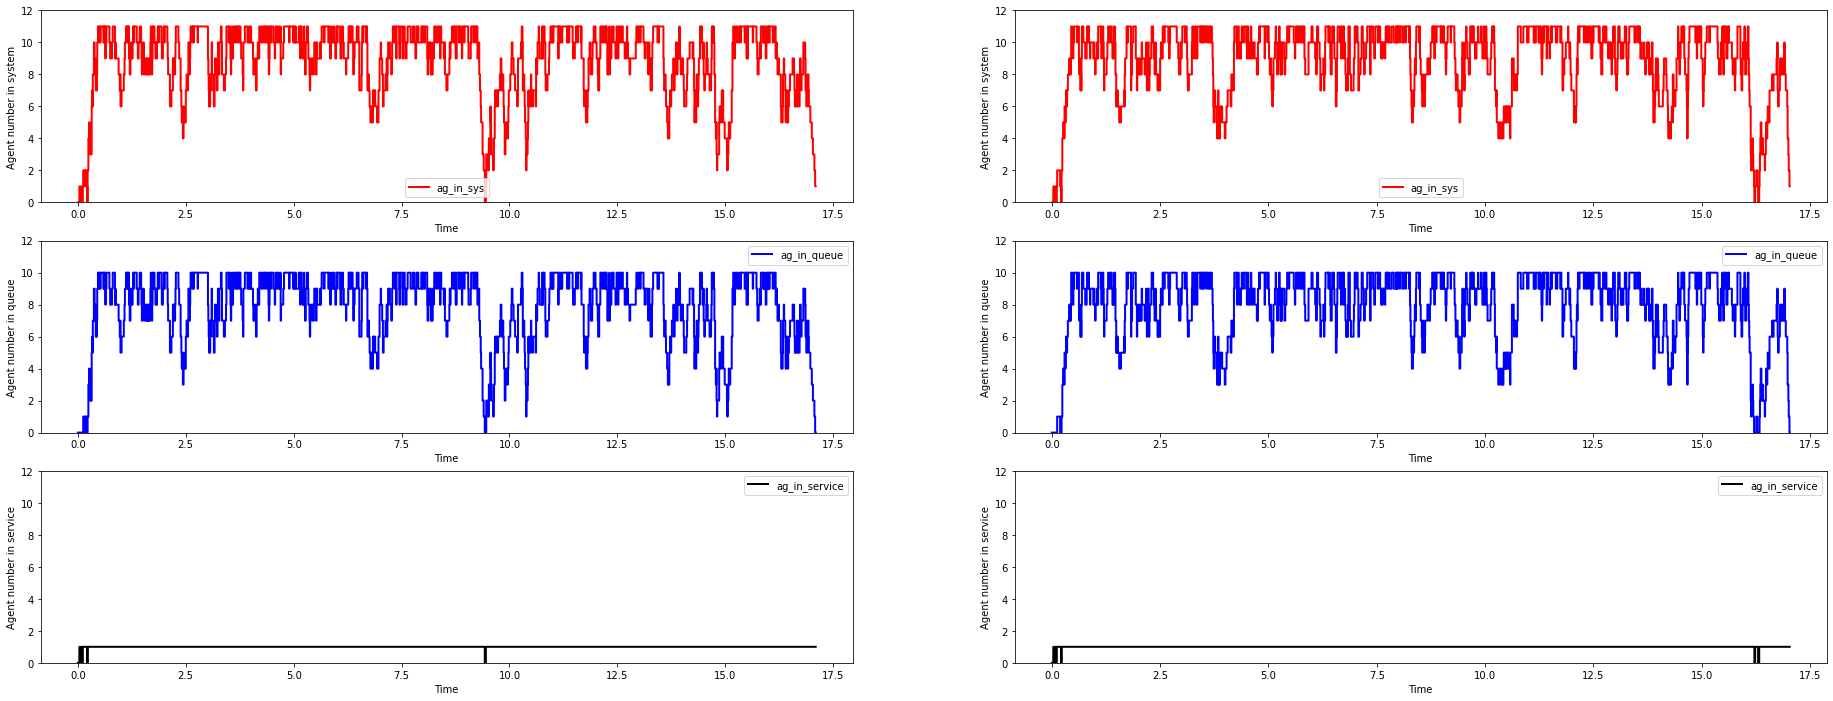

In [77]:
fig, axes = plt.subplots(3, 2, figsize=(32, 12))
counts = ['ag_in_sys','ag_in_queue','ag_in_service']
labels = ['system', 'queue', 'service']
colors = ['red', 'blue', 'black']

for i in range(3):
    mm1_fifo_bench.plot(y= counts[i], 
                   use_index=True, ax=axes[i,0], linewidth=2,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(mm1_fifo_bench['ag_in_sys']+1)])
    
    mm1_lifo_bench.plot(y= counts[i], 
                   use_index=True, ax=axes[i,1], linewidth=2,drawstyle='steps-mid', color=f'{colors[i]}',
                   ylabel=f'Agent number in {labels[i]}', xlabel='Time', ylim=[0,max(mm1_lifo_bench['ag_in_sys']+1)])

0.05694224555200032
_next : 0
Current Time:  0.30694224555200034
Current Queue: [1, 2]
_next : 1
Current Time:  0.5569422455520003
Current Queue: [2, 3]
_next : 2
Current Time:  0.8069422455520003
Current Queue: [3, 4]
_next : 3
Current Time:  1.0569422455520003
Current Queue: [4, 5]
_next : 4
Current Time:  1.3069422455520003
Current Queue: [5, 6]
_next : 5
Current Time:  1.5569422455520003
Current Queue: [6]
_next : 6
Current Time:  1.8069422455520003
Current Queue: [7, 8, 9]
_next : 7
Current Time:  2.0569422455520003
Current Queue: [8, 9, 10]
_next : 8
Current Time:  2.3069422455520003
Current Queue: [9, 10, 11]
_next : 9
Current Time:  2.5569422455520003
Current Queue: [10, 11]
_next : 10
Current Time:  2.8069422455520003
Current Queue: [11, 12, 13]
_next : 11
Current Time:  3.0569422455520003
Current Queue: [12, 13, 14, 15]
_next : 12
Current Time:  3.3069422455520003
Current Queue: [13, 14, 15, 16, 17]
_next : 13
Current Time:  3.5569422455520003
Current Queue: [14, 15, 16, 17, 

Current Time:  36.806942245552
Current Queue: [149, 150, 151, 152, 153, 154]
_next : 149
Current Time:  37.056942245552
Current Queue: [150, 151, 152, 153, 154, 155]
_next : 150
Current Time:  37.306942245552
Current Queue: [151, 152, 153, 154, 155]
_next : 151
Current Time:  37.556942245552
Current Queue: [152, 153, 154, 155, 156, 157]
_next : 152
Current Time:  37.806942245552
Current Queue: [153, 154, 155, 156, 157, 158]
_next : 153
Current Time:  38.056942245552
Current Queue: [154, 155, 156, 157, 158]
_next : 154
Current Time:  38.306942245552
Current Queue: [155, 156, 157, 158]
_next : 155
Current Time:  38.556942245552
Current Queue: [156, 157, 158]
_next : 156
Current Time:  38.806942245552
Current Queue: [157, 158]
_next : 157
Current Time:  39.056942245552
Current Queue: [158]
_next : 158
Current Time:  39.306942245552
Current Queue: []
Current Time:  39.565057821217465
Current Queue: [159]
_next : 159
Current Time:  39.815057821217465
Current Queue: []
Current Time:  40.1855

Current Time:  72.68550172624091
Current Queue: [293, 294, 295]
_next : 293
Current Time:  72.93550172624091
Current Queue: [294, 295]
_next : 294
Current Time:  73.18550172624091
Current Queue: [295, 296]
_next : 295
Current Time:  73.43550172624091
Current Queue: [296, 297, 298]
_next : 296
Current Time:  73.68550172624091
Current Queue: [297, 298]
_next : 297
Current Time:  73.93550172624091
Current Queue: [298]
_next : 298
Current Time:  74.18550172624091
Current Queue: [299, 300]
_next : 299
Current Time:  74.43550172624091
Current Queue: [300, 301]
_next : 300
Current Time:  74.68550172624091
Current Queue: [301, 302]
_next : 301
Current Time:  74.93550172624091
Current Queue: [302, 303]
_next : 302
Current Time:  75.18550172624091
Current Queue: [303, 304]
_next : 303
Current Time:  75.43550172624091
Current Queue: [304, 305, 306, 307, 308]
_next : 304
Current Time:  75.68550172624091
Current Queue: [305, 306, 307, 308]
_next : 305
Current Time:  75.93550172624091
Current Queue:

Current Time:  108.1907627002813
Current Queue: [432, 433, 434]
_next : 432
Current Time:  108.4407627002813
Current Queue: [433, 434]
_next : 433
Current Time:  108.6907627002813
Current Queue: [434]
_next : 434
Current Time:  108.9407627002813
Current Queue: []
Current Time:  109.24037339930774
Current Queue: [435]
_next : 435
Current Time:  109.49037339930774
Current Queue: []
Current Time:  109.6843726348882
Current Queue: [436]
_next : 436
Current Time:  109.9343726348882
Current Queue: [437, 438, 439]
_next : 437
Current Time:  110.1843726348882
Current Queue: [438, 439]
_next : 438
Current Time:  110.4343726348882
Current Queue: [439]
_next : 439
Current Time:  110.6843726348882
Current Queue: []
Current Time:  110.72463202265325
Current Queue: [440]
_next : 440
Current Time:  110.97463202265325
Current Queue: [441]
_next : 441
Current Time:  111.22463202265325
Current Queue: [442]
_next : 442
Current Time:  111.47463202265325
Current Queue: []
Current Time:  111.61548453199575


Current Time:  145.743913615559
Current Queue: [570, 571, 573, 574, 575, 576, 577, 578, 579]
_next : 570
Current Time:  145.993913615559
Current Queue: [571, 573, 574, 575, 576, 577, 578, 579, 580]
_next : 571
Current Time:  146.243913615559
Current Queue: [573, 574, 575, 576, 577, 578, 579, 580, 581]
_next : 573
Current Time:  146.493913615559
Current Queue: [574, 575, 576, 577, 578, 579, 580, 581, 582, 583]
_next : 574
Current Time:  146.743913615559
Current Queue: [575, 576, 577, 578, 579, 580, 581, 582, 583, 584]
_next : 575
Current Time:  146.993913615559
Current Queue: [576, 577, 578, 579, 580, 581, 582, 583, 584]
_next : 576
Current Time:  147.243913615559
Current Queue: [577, 578, 579, 580, 581, 582, 583, 584]
_next : 577
Current Time:  147.493913615559
Current Queue: [578, 579, 580, 581, 582, 583, 584, 587]
_next : 578
Current Time:  147.743913615559
Current Queue: [579, 580, 581, 582, 583, 584, 587]
_next : 579
Current Time:  147.993913615559
Current Queue: [580, 581, 582, 58

Current Time:  183.6497652278821
Current Queue: [702, 703, 704, 705, 706]
_next : 702
Current Time:  183.8997652278821
Current Queue: [703, 704, 705, 706, 707]
_next : 703
Current Time:  184.1497652278821
Current Queue: [704, 705, 706, 707, 708]
_next : 704
Current Time:  184.3997652278821
Current Queue: [705, 706, 707, 708]
_next : 705
Current Time:  184.6497652278821
Current Queue: [706, 707, 708, 709]
_next : 706
Current Time:  184.8997652278821
Current Queue: [707, 708, 709, 710]
_next : 707
Current Time:  185.1497652278821
Current Queue: [708, 709, 710, 711]
_next : 708
Current Time:  185.3997652278821
Current Queue: [709, 710, 711, 712]
_next : 709
Current Time:  185.6497652278821
Current Queue: [710, 711, 712]
_next : 710
Current Time:  185.8997652278821
Current Queue: [711, 712]
_next : 711
Current Time:  186.1497652278821
Current Queue: [712, 713]
_next : 712
Current Time:  186.3997652278821
Current Queue: [713]
_next : 713
Current Time:  186.6497652278821
Current Queue: [714,

Current Time:  218.22427425915163
Current Queue: [835, 836, 837, 838, 839, 840, 841, 842, 843]
_next : 835
Current Time:  218.47427425915163
Current Queue: [836, 837, 838, 839, 840, 841, 842, 843]
_next : 836
Current Time:  218.72427425915163
Current Queue: [837, 838, 839, 840, 841, 842, 843, 844, 845]
_next : 837
Current Time:  218.97427425915163
Current Queue: [838, 839, 840, 841, 842, 843, 844, 845, 846]
_next : 838
Current Time:  219.22427425915163
Current Queue: [839, 840, 841, 842, 843, 844, 845, 846]
_next : 839
Current Time:  219.47427425915163
Current Queue: [840, 841, 842, 843, 844, 845, 846]
_next : 840
Current Time:  219.72427425915163
Current Queue: [841, 842, 843, 844, 845, 846, 847, 848]
_next : 841
Current Time:  219.97427425915163
Current Queue: [842, 843, 844, 845, 846, 847, 848, 849]
_next : 842
Current Time:  220.22427425915163
Current Queue: [843, 844, 845, 846, 847, 848, 849, 850]
_next : 843
Current Time:  220.47427425915163
Current Queue: [844, 845, 846, 847, 84

Current Time:  250.97867812460734
Current Queue: [974, 975, 977, 979, 980, 981, 982, 983, 984, 985]
_next : 974
Current Time:  251.22867812460734
Current Queue: [975, 977, 979, 980, 981, 982, 983, 984, 985]
_next : 975
Current Time:  251.47867812460734
Current Queue: [977, 979, 980, 981, 982, 983, 984, 985, 986]
_next : 977
Current Time:  251.72867812460734
Current Queue: [979, 980, 981, 982, 983, 984, 985, 986, 987, 988]
_next : 979
Current Time:  251.97867812460734
Current Queue: [980, 981, 982, 983, 984, 985, 986, 987, 988, 990]
_next : 980
Current Time:  252.22867812460734
Current Queue: [981, 982, 983, 984, 985, 986, 987, 988, 990, 992]
_next : 981
Current Time:  252.47867812460734
Current Queue: [982, 983, 984, 985, 986, 987, 988, 990, 992, 993]
_next : 982
Current Time:  252.72867812460734
Current Queue: [983, 984, 985, 986, 987, 988, 990, 992, 993, 994]
_next : 983
Current Time:  252.97867812460734
Current Queue: [984, 985, 986, 987, 988, 990, 992, 993, 994]
_next : 984
Current

Current Time:  27.806942245552
Current Queue: [7, 49, 81, 85, 109, 110, 112, 113, 120, 121]
_next : 121
Current Time:  28.056942245552
Current Queue: [7, 49, 81, 85, 109, 110, 112, 113, 120]
_next : 120
Current Time:  28.306942245552
Current Queue: [7, 49, 81, 85, 109, 110, 112, 113]
_next : 113
Current Time:  28.556942245552
Current Queue: [7, 49, 81, 85, 109, 110, 112]
_next : 112
Current Time:  28.806942245552
Current Queue: [7, 49, 81, 85, 109, 110]
_next : 110
Current Time:  29.056942245552
Current Queue: [7, 49, 81, 85, 109, 123]
_next : 123
Current Time:  29.306942245552
Current Queue: [7, 49, 81, 85, 109]
_next : 109
Current Time:  29.556942245552
Current Queue: [7, 49, 81, 85, 124, 125]
_next : 125
Current Time:  29.806942245552
Current Queue: [7, 49, 81, 85, 124]
_next : 124
Current Time:  30.056942245552
Current Queue: [7, 49, 81, 85, 126, 127]
_next : 127
Current Time:  30.306942245552
Current Queue: [7, 49, 81, 85, 126]
_next : 126
Current Time:  30.556942245552
Current Qu

Current Time:  63.685501726240915
Current Queue: [161, 228, 229, 250, 260, 261]
_next : 261
Current Time:  63.935501726240915
Current Queue: [161, 228, 229, 250, 260, 262]
_next : 262
Current Time:  64.18550172624091
Current Queue: [161, 228, 229, 250, 260, 263]
_next : 263
Current Time:  64.43550172624091
Current Queue: [161, 228, 229, 250, 260]
_next : 260
Current Time:  64.68550172624091
Current Queue: [161, 228, 229, 250, 264, 265, 266, 267, 268]
_next : 268
Current Time:  64.93550172624091
Current Queue: [161, 228, 229, 250, 264, 265, 266, 267, 269]
_next : 269
Current Time:  65.18550172624091
Current Queue: [161, 228, 229, 250, 264, 265, 266, 267, 270, 271]
_next : 271
Current Time:  65.43550172624091
Current Queue: [161, 228, 229, 250, 264, 265, 266, 267, 270]
_next : 270
Current Time:  65.68550172624091
Current Queue: [161, 228, 229, 250, 264, 265, 266, 267, 272]
_next : 272
Current Time:  65.93550172624091
Current Queue: [161, 228, 229, 250, 264, 265, 266, 267]
_next : 267
Cur

Current Time:  97.1907627002813
Current Queue: [388, 389, 390, 391, 392]
_next : 392
Current Time:  97.4407627002813
Current Queue: [388, 389, 390, 391, 393]
_next : 393
Current Time:  97.6907627002813
Current Queue: [388, 389, 390, 391, 394, 395]
_next : 395
Current Time:  97.9407627002813
Current Queue: [388, 389, 390, 391, 394, 396]
_next : 396
Current Time:  98.1907627002813
Current Queue: [388, 389, 390, 391, 394, 397]
_next : 397
Current Time:  98.4407627002813
Current Queue: [388, 389, 390, 391, 394, 398]
_next : 398
Current Time:  98.6907627002813
Current Queue: [388, 389, 390, 391, 394, 399]
_next : 399
Current Time:  98.9407627002813
Current Queue: [388, 389, 390, 391, 394, 400, 401]
_next : 401
Current Time:  99.1907627002813
Current Queue: [388, 389, 390, 391, 394, 400, 402, 403]
_next : 403
Current Time:  99.4407627002813
Current Queue: [388, 389, 390, 391, 394, 400, 402, 404, 405]
_next : 405
Current Time:  99.6907627002813
Current Queue: [388, 389, 390, 391, 394, 400, 40

Current Time:  130.15027357769802
Current Queue: [489, 490, 515]
_next : 515
Current Time:  130.40027357769802
Current Queue: [489, 490, 516]
_next : 516
Current Time:  130.65027357769802
Current Queue: [489, 490]
_next : 490
Current Time:  130.90027357769802
Current Queue: [489, 517]
_next : 517
Current Time:  131.15027357769802
Current Queue: [489]
_next : 489
Current Time:  131.40027357769802
Current Queue: []
Current Time:  131.64302211932753
Current Queue: [518]
_next : 518
Current Time:  131.89302211932753
Current Queue: [519]
_next : 519
Current Time:  132.14302211932753
Current Queue: [520]
_next : 520
Current Time:  132.39302211932753
Current Queue: [521]
_next : 521
Current Time:  132.64302211932753
Current Queue: []
Current Time:  133.4851313231267
Current Queue: [522]
_next : 522
Current Time:  133.7351313231267
Current Queue: []
Current Time:  133.84027378537758
Current Queue: [523]
_next : 523
Current Time:  134.09027378537758
Current Queue: [524]
_next : 524
Current Time

Current Time:  168.15007403397692
Current Queue: [649]
_next : 649
Current Time:  168.40007403397692
Current Queue: [650]
_next : 650
Current Time:  168.65007403397692
Current Queue: [651]
_next : 651
Current Time:  168.90007403397692
Current Queue: []
Current Time:  169.3828156030258
Current Queue: [652]
_next : 652
Current Time:  169.6328156030258
Current Queue: [653, 654]
_next : 654
Current Time:  169.8828156030258
Current Queue: [653]
_next : 653
Current Time:  170.1328156030258
Current Queue: [655]
_next : 655
Current Time:  170.3828156030258
Current Queue: [656, 657]
_next : 657
Current Time:  170.6328156030258
Current Queue: [656, 658]
_next : 658
Current Time:  170.8828156030258
Current Queue: [656]
_next : 656
Current Time:  171.1328156030258
Current Queue: [659]
_next : 659
Current Time:  171.3828156030258
Current Queue: [660, 661, 662]
_next : 662
Current Time:  171.6328156030258
Current Queue: [660, 661, 663]
_next : 663
Current Time:  171.8828156030258
Current Queue: [660

Current Time:  204.81931650860423
Current Queue: [776, 777, 780, 785]
_next : 785
Current Time:  205.06931650860423
Current Queue: [776, 777, 780]
_next : 780
Current Time:  205.31931650860423
Current Queue: [776, 777, 786, 787]
_next : 787
Current Time:  205.56931650860423
Current Queue: [776, 777, 786, 788, 789]
_next : 789
Current Time:  205.81931650860423
Current Queue: [776, 777, 786, 788, 790, 791]
_next : 791
Current Time:  206.06931650860423
Current Queue: [776, 777, 786, 788, 790, 792]
_next : 792
Current Time:  206.31931650860423
Current Queue: [776, 777, 786, 788, 790, 793]
_next : 793
Current Time:  206.56931650860423
Current Queue: [776, 777, 786, 788, 790, 794]
_next : 794
Current Time:  206.81931650860423
Current Queue: [776, 777, 786, 788, 790]
_next : 790
Current Time:  207.06931650860423
Current Queue: [776, 777, 786, 788, 795]
_next : 795
Current Time:  207.31931650860423
Current Queue: [776, 777, 786, 788]
_next : 788
Current Time:  207.56931650860423
Current Queue:

Current Time:  239.47867812460734
Current Queue: [902, 903, 904, 916, 920, 921]
_next : 921
Current Time:  239.72867812460734
Current Queue: [902, 903, 904, 916, 920, 922]
_next : 922
Current Time:  239.97867812460734
Current Queue: [902, 903, 904, 916, 920, 923, 924]
_next : 924
Current Time:  240.22867812460734
Current Queue: [902, 903, 904, 916, 920, 923, 925]
_next : 925
Current Time:  240.47867812460734
Current Queue: [902, 903, 904, 916, 920, 923, 926, 927]
_next : 927
Current Time:  240.72867812460734
Current Queue: [902, 903, 904, 916, 920, 923, 926, 928]
_next : 928
Current Time:  240.97867812460734
Current Queue: [902, 903, 904, 916, 920, 923, 926]
_next : 926
Current Time:  241.22867812460734
Current Queue: [902, 903, 904, 916, 920, 923, 929, 930]
_next : 930
Current Time:  241.47867812460734
Current Queue: [902, 903, 904, 916, 920, 923, 929]
_next : 929
Current Time:  241.72867812460734
Current Queue: [902, 903, 904, 916, 920, 923, 931, 932]
_next : 932
Current Time:  241.9

,run value_fifo,run value_lifo
mean_sojourn_time,1.334576,1.334576
mean_waiting_time,1.084576,1.084576
mean_service_time,0.25,0.25
waiting_proportion,0.945361,0.945361
blocked_proportion,0.03,0.03
servers_max_usage,0.947474,0.947474
longest_wait_time,2.498004,37.401151
wait_time_std,0.712511,3.199509


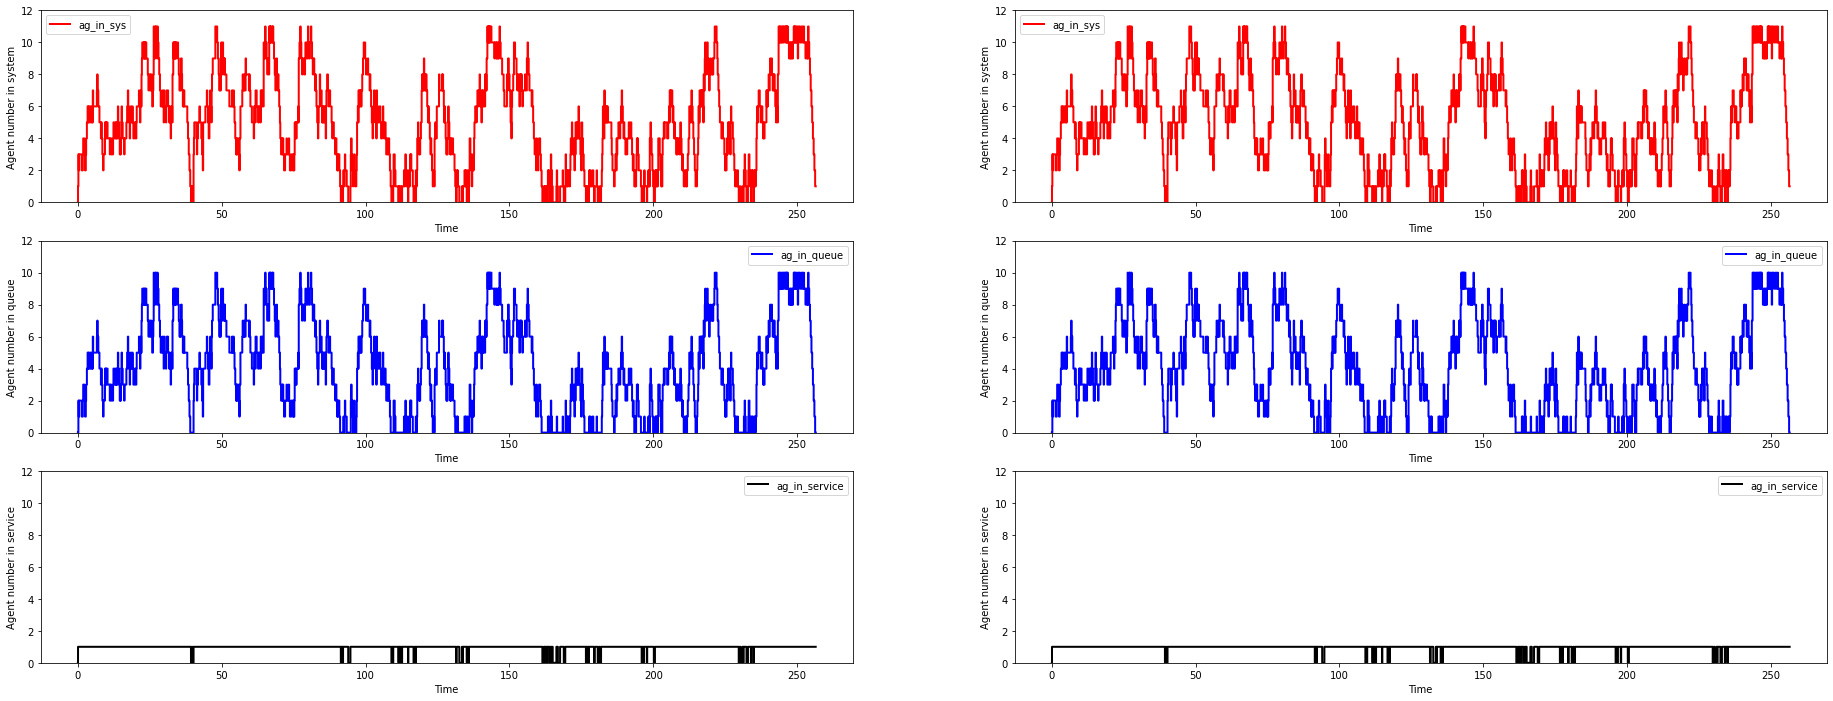

In [85]:
#signature : simulate(srv_nb, queue_size, test_size, seed, arrival_speed: float, srv_speed: float):


simulate(1, 10, 1000, 42, 1./4., 1./4)

# Question 2

On suppose avoir à diposition $5$ serveurs $s_1$, $\ldots$, $s_5$ et $3$ files d'arrivées *FIFO* $f_1$, $f_1$, $f_3$ de tailles respectives $z_1$, $z_2$, $z_3$. Les temps de services de nos serveurs sont respectivements donnés par des lois exponentielles paramètres $\mu_1$, $\ldots$, $\mu_5$, ordonnés par ordre croissant.  

Une population d'agents s'adresse à notre service, déployé identitiquement sur chaque serveur. On constate que cette population est décomposée en $5$ sous-populations $A_1$, $\ldots$, $A_5$ dont les processus d'arrivées sont respectivement d'intensités $\lambda_1$, $\ldots$, $\lambda_5$, ordonnés par ordre croissants. Les tailles respectives de chacune des populations sont $a_1$, $\ldots$, $a_5$ ; elles vérifient les relations $a_i > 2\max\{z_1, z_2, z_3\}$ pour tout $1 \leq i \leq 3$.   

1. Simuler un système d'attente qui permet de répondre aux besoins de services.
2. Comparer un minimum de trois architectures possibles, au regard des ressources à disposition, pour répondre aux besoins de services. Vous êtes attendus sur des simulations appuyants vos propos.
3. Quelles modifications apporteriez-vous sur votre proposition si l'on introduit une fonction de dissatisfaction des agents donnée par $ b_1 + 2 b_2 + \cdots 5 b_5$, où $b_i$ correspond au nombre d'agents de la populations $A_i$ qui n'ont pas pu avoir accès au système ?

Vous êtes autorisé d'effectuer des hypothèses simplificatrices dans votre travail. Attention à ce qu'elles ne soient pas *trop* simplificatrices.